## **Project 8 Ensemble Methods**

## **TODO: Tiffany Akwarandu

### **Introduction**  

You are a data analyst at a **financial services company**, tasked with improving the effectiveness of a **marketing campaign** that promotes term deposit subscriptions. Your goal is to build a **machine learning model** that predicts whether a customer will subscribe to a term deposit based on their demographics, banking history, and previous interactions with the campaign.  

To improve prediction accuracy and model robustness, you will explore three **ensemble methods**:  

- **AdaBoost**  
- **XGBoost**  
- **Random Forest**  

At the end of the assignment, you will analyze and compare the performance of these models and recommend the best approach for **optimizing marketing outreach** and improving customer conversion rates.  

### **Dataset**  

To accomplish this task, you will use the **Bank Marketing Dataset** from Kaggle:  

🔗 **Dataset Link:** [Bank Marketing Dataset](https://www.kaggle.com/datasets/janiobachmann/bank-marketing-dataset/data)  You can review the annotations about the dataset on the Kaggle site but the CSV file is also provided with your assignment.

This dataset consists of **over 11,000 customer records**, each containing demographic and financial attributes, as well as details of previous marketing interactions. The key features in this dataset include:  

- **Age**: Customer’s age.  
- **Job**: Type of job (e.g., admin, blue-collar, technician, services).  
- **Marital Status**: Single, married, or divorced.  
- **Education**: Level of education attained.  
- **Balance**: Customer's account balance.  
- **Housing Loan**: Whether the customer has a housing loan (yes/no).  
- **Personal Loan**: Whether the customer has a personal loan (yes/no).  
- **Contact Method**: Communication type (e.g., cellular, telephone).  
- **Last Campaign Outcome**: Result of the previous marketing campaign.  
- **Duration**: Call duration in seconds.  

The **target variable** is **"deposit"**, which indicates whether the customer subscribed to a term deposit (**1/0**).  

### **Task**  

Your objective is to develop and compare different **ensemble learning models** to predict whether a customer will subscribe to a term deposit and determine which model performs best for **targeted marketing optimization**.  


In [ ]:
# These are the libraries you will use for this assignment, you may not import anything else
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, RocCurveDisplay, auc
from xgboost import XGBClassifier
import time

#### **Utilizing the provided Bank Marketing Dataset data, we will employ methods from sklearn for cross-validation to estimate error.**



In [ ]:
df = pd.read_csv('bank.csv')

In [ ]:
# Print the shape
df.shape





(11162, 17)

In [ ]:
# Print head of DF
df.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


## **Q1: Exploratory Data Analysis (EDA)**

Explore the dataset.

**1.1 Class Distribution**  
- Plot the distribution of the target variable (`deposit`).  

**1.2 Unique Values & Data Quality Check**  
- Display the unique values for at least two categorical features (e.g., `job` and `education`).

**1.3 Grouped Analysis**
- Use **groupby()** to analyze the average **balance** of customers based on their **education** level.
- Do the same thing for **marital** status. Print both values.

**1.4 Visualizing a Numerical Feature**  
- Plot the `age` column to observe the distribution of customer ages.  

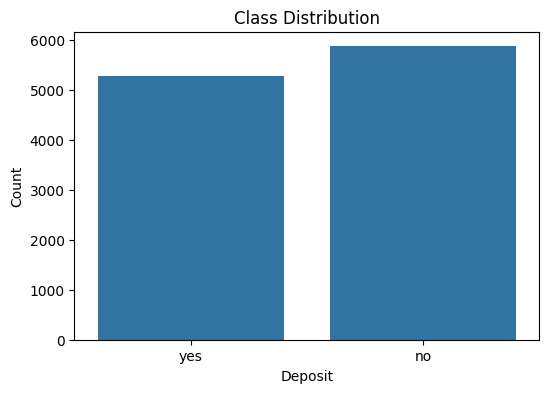

In [ ]:
# 1.1 Class Distribution
plt.figure(figsize=(6,4))
sns.countplot(x=df['deposit'])
plt.title('Class Distribution')
plt.xlabel('Deposit')
plt.ylabel('Count')
plt.show()


In [ ]:
# 1.2 Unique Values & Data Quality Check
unique_jobs = df['job'].unique()
print("\nUnique Jobs:", unique_jobs)

unique_education = df['education'].unique
print("\nUnique Education Levels:", unique_education)



Unique Jobs: ['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'unknown' 'self-employed'
 'student']

Unique Education Levels: <bound method Series.unique of 0        secondary
1        secondary
2        secondary
3        secondary
4         tertiary
           ...    
11157      primary
11158    secondary
11159    secondary
11160    secondary
11161    secondary
Name: education, Length: 11162, dtype: object>


In [ ]:
# 1.3 Average Balance by Education
edu_balance = df.groupby('education')['balance'].mean()

print("\nAverage Balance by Education Level:", edu_balance)

mar_balance = df.groupby('marital')['balance'].mean()
print("\nAverage Balance by Marital Status:", mar_balance)


Average Balance by Education Level: education
primary      1523.031333
secondary    1296.480278
tertiary     1845.869070
unknown      1746.605634
Name: balance, dtype: float64

Average Balance by Marital Status: marital
divorced    1371.835267
married     1599.927570
single      1457.255259
Name: balance, dtype: float64


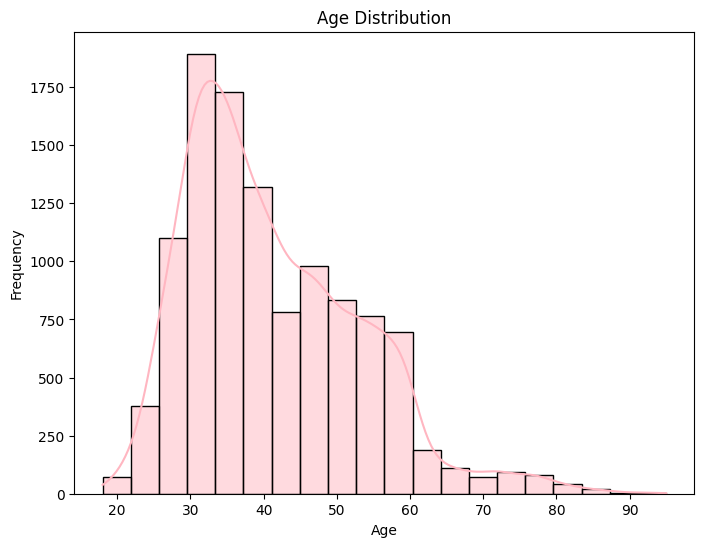

In [ ]:
# 1.4 Age Distribution Histogram
plt.figure(figsize=(8, 6))
sns.histplot(df['age'], bins=20, kde=True, color= 'lightpink')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


## **Q2 Data Pre-Processing**

This section focuses on preparing the data by encoding categorical features and ensuring it is ready for modeling.

### **2.1 Encode Categorical Variables**
- Identify categorical columns that contain non-numeric values.
- Convert categorical features into **numerical** format using [Label Encoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html). Feel free to look at the documentation to get a better idea on what we are doing in this step.
- Store the encoders to allow potential inverse transformations if needed later.

In [ ]:
from sklearn.preprocessing import LabelEncoder
# Get categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('deposit')

# Encode categorical features using Label Encoding
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

    if df['deposit'].dtype == 'object':
        le_target = LabelEncoder()
        df['deposit'] = le_target.fit_transform(df['deposit'])
        label_encoders['deposit'] = le_target


## **Q3 Partition the data for cross validation**

Import the dataset and divide it into two parts: 𝑋 (features, stored in `df_X`) and 𝑦 (target, stored in `s_y`). Establish our data partitions.

Given the significant imbalance in the dataset, there's concern about the target class being insufficiently represented in a random k-fold split. To address this, we opt for a [stratified k-fold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) approach, which ensures the preservation of class proportions across our tests. We'll use `𝑘=3`. Create a `StratifiedKFold` instance and utilize its `split` method to fill the training and testing dictionaries.

   - `d_train_df_X` : key is the fold number, value is the attribute training dataframe at that fold
   - `d_test_df_X`  : key is the fold number, value is the attribute test dataframe at that fold
   - `d_train_s_y`  : key is the fold number, value is the target training series at that fold
   - `d_train_s_y`  : key is the fold number, value is the target test series at that fold

In [ ]:
df_X = df.drop(columns=["deposit"])
s_y = df["deposit"]
skf = StratifiedKFold(n_splits=3,shuffle=True,random_state=23)


d_train_df_X = dict()
d_test_df_X = dict()
d_train_s_y = dict()
d_test_s_y = dict()
k = 1

# Write your code here
for train_index, test_index in skf.split(df_X, s_y):
    d_train_df_X[k] = df_X.iloc[train_index].reset_index(drop=True)
    d_test_df_X[k] = df_X.iloc[test_index].reset_index(drop=True)
    d_train_s_y[k] = s_y.iloc[train_index].reset_index(drop=True)
    d_test_s_y[k] = s_y.iloc[test_index].reset_index(drop=True)
    k += 1


In [ ]:
# Observe the test data and verify that the target training is as equally distributed as possible
for key in d_test_s_y.keys():
    print(f"\nFold {key} target distribution:")
    print(d_test_s_y[key].value_counts())


Fold 1 target distribution:
deposit
0    1958
1    1763
Name: count, dtype: int64

Fold 2 target distribution:
deposit
0    1958
1    1763
Name: count, dtype: int64

Fold 3 target distribution:
deposit
0    1957
1    1763
Name: count, dtype: int64


## **Q3: Implementing AdaBoost and Random Forest Classifiers using a Generalized Function**

### **Overview**
As we learned in class, ensemble methods combine multiple models to improve overall prediction performance. In this assignment, you will work with two ensemble methods:

1. **AdaBoost** – A boosting method that starts with a weak classifier (commonly a decision stump, i.e., a decision tree with `max_depth=1`) and iteratively focuses on misclassified instances.
2. **Random Forest** – A bagging method that builds many decision trees (using random subsets of features at each split) and aggregates their predictions via majority voting.

Rather than writing separate functions for each classifier, you will use a **generalized function** called `train_and_plot_model()` that:
- Trains a given classifier using 3-fold cross-validation.
- Computes evaluation metrics (Accuracy, True Positive Rate, Positive Predictive Value, and False Positive Rate) for each fold.
- Plots the ROC curve for each fold using `roc_curve` and `RocCurveDisplay` from Scikit-learn.
- Returns the predictions from the 3rd fold (stored in a variable, e.g., `y_hat_ab` for AdaBoost and `y_hat_rf` for Random Forest).

### **Task Details**
1. **Model Training and Prediction:**
   - For **AdaBoost**, instantiate the classifier with:
     ```python
     AdaBoostClassifier(n_estimators=25, random_state=23)
     ```
   - For **Random Forest**, instantiate the classifier with:
     ```python
     RandomForestClassifier(criterion="entropy", max_features="sqrt", random_state=23)
     ```
   - Train the model on the training data (using the provided cross-validation splits) and use either `predict` or `predict_proba` to generate predictions.
   - **Note:** predict_proba is typically used for Random Forest, as it outputs the probability estimates for each class. decision_function is used for AdaBoost.

2. **Metrics Calculation:**
   - For each fold, calculate:
     - Accuracy
     - True Positive Rate (TPR)
     - Positive Predictive Value (PPV)
     - False Positive Rate (FPR)

3. **ROC Curve Plotting:**
   - Plot the ROC curve for each fold. You may use Scikit-learn’s `roc_curve` and `RocCurveDisplay` functions.
   - Refer to the Scikit-learn documentation for an example on plotting ROC curves in cross-validation.

4. **Saving Predictions:**
   - After iterating over all folds, save the predictions from the 3rd fold into a variable:
     - `y_hat_ab` for AdaBoost
     - `y_hat_rf` for Random Forest
   - Your function should include a complete docstring.

*Note:* Ensemble methods like AdaBoost focus on misclassified instances, which may take some time depending on the data size and the number of estimators. Please be patient.

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, RocCurveDisplay, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def train_and_plot_model(model, model_name, train_X, train_y, test_X, test_y, k=3):
    '''
    Trains a given classifier using cross-validation and plots the ROC curve.

    Parameters:
    - model: A Scikit-learn classifier instance (e.g., AdaBoostClassifier or RandomForestClassifier).
    - model_name: A string representing the model name (used for labeling plots).
    - train_X, train_y: Training data dictionaries (from cross-validation splits).
    - test_X, test_y: Test data dictionaries (from cross-validation splits).
    - k: Number of cross-validation folds.

    Returns:
    - y_hat: numpy array, Predictions for the instances in the test set for the 3rd fold.
    '''

    acc = np.zeros(k)
    tpr = np.zeros(k)
    ppv = np.zeros(k)
    fpr = np.zeros(k)

    fold_count = 0
    fig, ax = plt.subplots()

    for key in train_X.keys():
        print(f"Training {model_name} on Fold {key}")

        # Train model
        model.fit(train_X[key], train_y[key])

        # Get decision scores (if available) or use predicted probabilities for the positive class
        if hasattr(model, "decision_function"):
            y_scores = model.decision_function(test_X[key])
        else:
            y_scores = model.predict_proba(test_X[key])[:, 1]

        y_pred = model.predict(test_X[key])

        # Save 3rd fold predictions
        if key == 3:
            y_hat = y_pred

        # Compute ROC values
        fpr_vals, tpr_vals, _ = roc_curve(test_y[key], y_scores)

        # Plot ROC curve
        RocCurveDisplay(fpr=fpr_vals, tpr=tpr_vals).plot(ax=ax, name=f"Fold {key}")

        # Compute metrics
        acc[fold_count] = accuracy_score(test_y[key], y_pred)

        cm = confusion_matrix(test_y[key], y_pred)
        tn, fp, fn, tp = cm.ravel()

        # True positive rate
        tpr[fold_count] = tp / (tp + fn) if (tp + fn) > 0 else 0

        # False positive rate
        fpr[fold_count] = fp / (fp + tn) if (fp + tn) > 0 else 0

        # Positive Predictive Value (avoid division by zero)
        ppv[fold_count] = tp / (tp + fp) if (tp + fp) > 0 else 0

        fold_count += 1

    # Print overall performance
    print(f"\n{model_name} Performance:")
    print(f'TPR - Min: {tpr.min():.2f}, Mean: {tpr.mean():.2f}, Max: {tpr.max():.2f}')
    print(f'PPV - Min: {ppv.min():.2f}, Mean: {ppv.mean():.2f}, Max: {ppv.max():.2f}')
    print(f'Accuracy - Min: {acc.min():.2f}, Mean: {acc.mean():.2f}, Max: {acc.max():.2f}')

    # Plot the ROC Curve
    plt.title(f"{model_name} ROC Curve Across Folds")
    plt.show()

    return y_hat

### Call train_and_plot_model()

- **Train both Random Forest and AdaBoost** with the specified hyperparameters.  
- Measure the **execution time** for each model in seconds.

Training AdaBoost on Fold 1
Training AdaBoost on Fold 2
Training AdaBoost on Fold 3

AdaBoost Performance:
TPR - Min: 0.76, Mean: 0.77, Max: 0.78
PPV - Min: 0.77, Mean: 0.78, Max: 0.79
Accuracy - Min: 0.78, Mean: 0.79, Max: 0.80


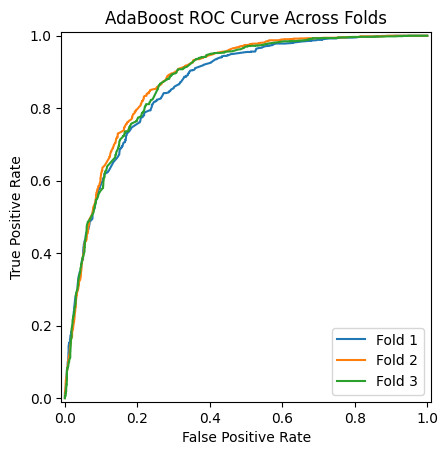

AdaBoost Training Time: 1.45 seconds


In [ ]:
# Write your code here

# Train AdaBoost model
ab_model = AdaBoostClassifier(n_estimators=25, random_state=23)

start = time.time()
y_hat_ab = train_and_plot_model(ab_model, "AdaBoost", d_train_df_X, d_train_s_y, d_test_df_X, d_test_s_y)
ab_runtime = time.time() - start
print(f"AdaBoost Training Time: {ab_runtime:.2f} seconds")

Training Random Forest on Fold 1
Training Random Forest on Fold 2
Training Random Forest on Fold 3

Random Forest Performance:
TPR - Min: 0.86, Mean: 0.86, Max: 0.87
PPV - Min: 0.81, Mean: 0.82, Max: 0.83
Accuracy - Min: 0.84, Mean: 0.84, Max: 0.85


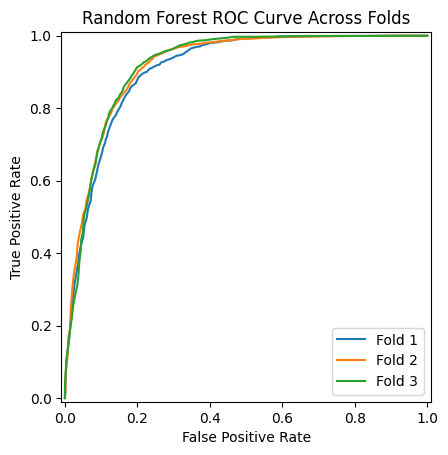

Random Forest Training Time: 4.85 seconds


In [ ]:
# Write your code here

# Train Random Forest model
rf_model = RandomForestClassifier(criterion="entropy", max_features="sqrt", random_state=23)

start = time.time()
y_hat_rf = train_and_plot_model(rf_model, "Random Forest", d_train_df_X, d_train_s_y, d_test_df_X, d_test_s_y)
rf_runtime = time.time() - start
print(f"Random Forest Training Time: {rf_runtime:.2f} seconds")

### **3.2 Compare AdaBoost and Random Forest**  

- **Which model is faster?** Compare the execution times of AdaBoost and Random Forest. Why do you think one is faster than the other?  

- **Which model has better predictive performance?** Compare accuracy, True Positive Rate (TPR), and False Positive Rate (FPR). Which model makes better predictions?  

- **Which model should the bank deploy?** Considering both speed and accuracy, which model is more suitable for the bank’s marketing strategy?


## WRITE ANSWER HERE
- Answer 1:  AdaBoost is faster (1.45 secs compared to the 4.85 secs for the Random Forest. This is because Ada trains a sequence of shallow trees, and Random Forest builds many deep decision trees, which takes longer.
- Answer 2: Random Forest has a better predictive performance.
- Answer 3:  Random Forest is better for the bank's strategy even though its slower. It has better accuracy and recall making it more effective to see which customers will suscribe to a bank term deposit.

## **Q4: Implementing XGBoost Classifier**

### **Overview**  
XGBoost (Extreme Gradient Boosting) is one of the most powerful and widely used machine learning algorithms, particularly for structured data tasks. It is an optimized implementation of gradient boosting that improves speed and performance through advanced techniques such as parallel tree boosting, regularization, and efficient handling of missing values.  

XGBoost is known for its ability to:  
- **Handle large datasets efficiently** by leveraging parallel computation.  
- **Prevent overfitting** through L1 (Lasso) and L2 (Ridge) regularization.  
- **Achieve state-of-the-art results** in machine learning competitions such as Kaggle.  
- **Support early stopping** to optimize performance during training.  

For more details on XGBoost, check out the following resources:  
- Official Documentation: [https://xgboost.readthedocs.io/en/stable/](https://xgboost.readthedocs.io/en/stable/)  
- Scikit-learn API for XGBoost: [https://xgboost.readthedocs.io/en/stable/python/sklearn_estimator.html](https://xgboost.readthedocs.io/en/stable/python/sklearn_estimator.html)  
- Gradient Boosting Explanation: [https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/](https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/)  

You will use **XGBoostClassifier** within the `train_and_plot_model()` function to evaluate its performance on the Bank Marketing Dataset.
-  Also store the time it takes to run the model.


Training XGBoost on Fold 1


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:27:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training XGBoost on Fold 2


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:27:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training XGBoost on Fold 3


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:27:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Performance:
TPR - Min: 0.86, Mean: 0.86, Max: 0.88
PPV - Min: 0.82, Mean: 0.83, Max: 0.83
Accuracy - Min: 0.84, Mean: 0.85, Max: 0.86


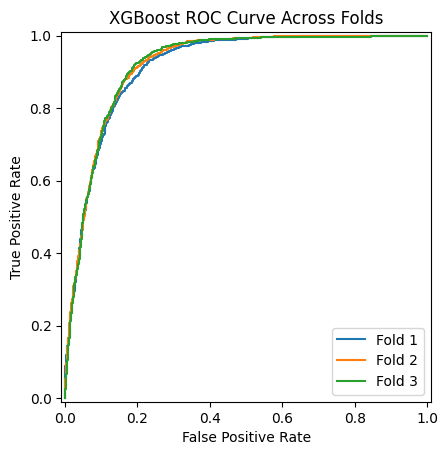

XGBoost Training Time: 1.80 seconds


In [ ]:
# Train and evaluate XGBoost using the existing function

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=23)

start = time.time()
y_hat_xgb = train_and_plot_model(xgb_model, "XGBoost", d_train_df_X, d_train_s_y, d_test_df_X, d_test_s_y)
xg_runtime = time.time() - start
print(f"XGBoost Training Time: {xg_runtime:.2f} seconds")

### **Q5 Calculate the Cost of Incorrect Predictions**

The bank is evaluating XGBoost and Random Forest for predicting term deposit subscriptions. Both models have similar accuracy, but XGBoost trains faster.

Since marketing outreach is expensive, the bank wants to estimate the financial impact of False Positives (FP) and False Negatives (FN) before deciding which model to deploy.


**Cost Assumptions:**

* False Positives (FP): $50 (marketing cost per incorrect prediction)

* False Negatives (FN): $500 (lost revenue per missed subscriber)

**Task:**

- Calculate the proportion of customers who subscribed using the dataset.
- Recalculate the True Positive Rate (TPR) and False Positive Rate (FPR) for
XGBoost and Random Forest using their predictions and actual labels.


Using these values, compute:
- The number of False Positives (FP)
- The number of False Negatives (FN)
- Compute the total financial loss for each model.

Considering both financial loss and training time, which model should the bank deploy?


In [ ]:
from sklearn.metrics import confusion_matrix

y_pred_xgb = y_hat_xgb  # Predictions from the last fold
y_pred_rf = y_hat_rf    # Predictions from the last fold

# Use correct test labels for the last fold (3rd fold)
fold_index = 3
y_test_xgb = d_test_s_y[fold_index]
y_test_rf = d_test_s_y[fold_index]

# Validate matching lengths
assert len(y_pred_xgb) == len(y_test_xgb), f"XGBoost: Mismatch in samples ({len(y_pred_xgb)} vs {len(y_test_xgb)})"
assert len(y_pred_rf) == len(y_test_rf), f"Random Forest: Mismatch in samples ({len(y_pred_rf)} vs {len(y_test_rf)})"

# Compute Confusion Matrices
cm_xgb = confusion_matrix(y_test_xgb, y_pred_xgb)
cm_rf = confusion_matrix(y_test_rf, y_pred_rf)

# Extract TN, FP, FN, TP values
TN_xgb, FP_xgb, FN_xgb, TP_xgb = cm_xgb.ravel()
TN_rf, FP_rf, FN_rf, TP_rf = cm_rf.ravel()

# Compute TPR and FPR for XGBoost and Random Forest
TPR_xgb = TP_xgb / (TP_xgb + FN_xgb) if (TP_xgb + FN_xgb) > 0 else 0
FPR_xgb = FP_xgb / (FP_xgb + TN_xgb) if (FP_xgb + TN_xgb) > 0 else 0

TPR_rf = TP_rf / (TP_rf + FN_rf) if (TP_rf + FN_rf) > 0 else 0
FPR_rf = FP_rf / (FP_rf + TN_rf) if (FP_rf + TN_rf) > 0 else 0

# Calculate the proportion of customers who subscribed
total_customers = len(df)
subscribed_proportion = df["deposit"].sum() / total_customers
actual_subscribers = df["deposit"].sum()
non_subscribers = total_customers - actual_subscribers

# Define Model Performance
models = {
    "XGBoost": {"TP": TP_xgb, "FP": FP_xgb, "FN": FN_xgb, "TPR": TPR_xgb, "FPR": FPR_xgb, "train_time": xg_runtime},
    "Random Forest": {"TP": TP_rf, "FP": FP_rf, "FN": FN_rf, "TPR": TPR_rf, "FPR": FPR_rf, "train_time": rf_runtime}
}

# Cost Parameters
cost_fp = 50   # Cost of marketing to a non-subscriber
cost_fn = 500  # Revenue lost for missing a true subscriber

# Compute FP, FN, and total cost
for model, metrics in models.items():
    TP = metrics["TP"]
    FP = metrics["FP"]
    FN = metrics["FN"]

    total_cost = (FP * cost_fp) + (FN * cost_fn)

    print(f"{model}: False Positives = {FP:.0f}, False Negatives = {FN:.0f}, Total Cost = ${total_cost:,.2f}")


XGBoost: False Positives = 302, False Negatives = 250, Total Cost = $140,100.00
Random Forest: False Positives = 322, False Negatives = 243, Total Cost = $137,600.00
